In [4]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df_calendar = pd.read_csv('./calendar.csv')
df_listings = pd.read_csv('./listings.csv')
df_reviews = pd.read_csv('./reviews.csv')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e27c668>,
      dtype=object)

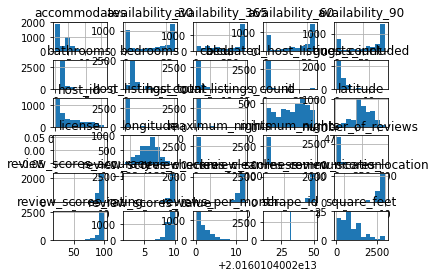

In [31]:
df_listings.hist()